In [1]:
!pip install tensorflow mediapipe tqdm scikit-learn opencv-python

In [2]:
!gdown --id 1gn8YFFnfxlmUi--42YhagXbkWzhzTo3q -O dynamic.zip

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gn8YFFnfxlmUi--42YhagXbkWzhzTo3q
To: /content/dynamic.zip
100% 898k/898k [00:00<00:00, 139MB/s]


In [3]:
!unzip dynamic.zip

Archive:  dynamic.zip
   creating: dynamic/
   creating: dynamic/aa/
   creating: dynamic/aa/npy/
  inflating: dynamic/aa/npy/aa_seq_0000.npy  
  inflating: dynamic/aa/npy/aa_seq_0001.npy  
  inflating: dynamic/aa/npy/aa_seq_0002.npy  
  inflating: dynamic/aa/npy/aa_seq_0003.npy  
  inflating: dynamic/aa/npy/aa_seq_0004.npy  
  inflating: dynamic/aa/npy/aa_seq_0005.npy  
  inflating: dynamic/aa/npy/aa_seq_0006.npy  
  inflating: dynamic/aa/npy/aa_seq_0007.npy  
  inflating: dynamic/aa/npy/aa_seq_0008.npy  
  inflating: dynamic/aa/npy/aa_seq_0009.npy  
   creating: dynamic/ee/
   creating: dynamic/ee/npy/
  inflating: dynamic/ee/npy/ee_seq_0000.npy  
  inflating: dynamic/ee/npy/ee_seq_0001.npy  
  inflating: dynamic/ee/npy/ee_seq_0002.npy  
  inflating: dynamic/ee/npy/ee_seq_0003.npy  
  inflating: dynamic/ee/npy/ee_seq_0004.npy  
  inflating: dynamic/ee/npy/ee_seq_0005.npy  
  inflating: dynamic/ee/npy/ee_seq_0006.npy  
  inflating: dynamic/ee/npy/ee_seq_0007.npy  
  inflating: dynamic

In [4]:
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

DATA_PATH = "/content/dynamic"

In [5]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())

def extract_keypoints(image, results):
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        return np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]) if hand_landmarks.landmark else np.zeros((21,3))

In [6]:
actions = np.array(os.listdir(DATA_PATH))
label_map = {label: num for num, label in enumerate(actions)}

data, labels = [], []

for label in tqdm(actions):
    path = os.path.join(DATA_PATH, label, "npy")
    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        try:
            keypoints = np.load(file_path)
            data.append(keypoints)
            labels.append(label_map[label])
        except Exception as e:
            print(f"Skipping file {file_path} due to error: {e}")

100%|██████████| 11/11 [00:00<00:00, 726.56it/s]


In [7]:
# Convert to arrays and one-hot encode labels
X = np.array(data)
y = to_categorical(labels).astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
SAVE_DIR = "/content/result"
os.makedirs(SAVE_DIR, exist_ok=True)
np.save(f"{SAVE_DIR}/X_train", X_train)
np.save(f"{SAVE_DIR}/X_test.npy", X_test)
np.save(f"{SAVE_DIR}/y_train.npy", y_train)
np.save(f"{SAVE_DIR}/y_test.npy", y_test)
print("Save data in npy format successfully!")

Save data in npy format successfully!


In [9]:
X_train.shape

(77, 30, 21, 3)

In [10]:
y_train.shape

(77, 11)

In [13]:
from keras.layers import Dense, LSTM
from keras.callbacks import TensorBoard
from keras.models import Sequential

log_dir = os.path.join("logs")
tb_callback = TensorBoard(log_dir=log_dir)

In [36]:
# Reshape to match the LSTM model input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 21*3))

model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 63)),
    # LSTM(128, return_sequences=True, activation='relu'), # Small dataset dont need big ANN model to learn
    LSTM(64, return_sequences=False, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(actions.shape[0], activation='softmax'),
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
model.fit(X_train, y_train, epochs=150, batch_size=8, callbacks=[tb_callback])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6215 - loss: 1.2622
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5504 - loss: 1.0980
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6780 - loss: 0.9997
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6465 - loss: 1.0968
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6449 - loss: 1.0029
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5704 - loss: 1.1056
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6367 - loss: 0.9446
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8100 - loss: 0.7794
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7810 - loss: 0.7133
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7451 - loss: 0.6950
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6371 - loss: 0.7309
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy:

In [40]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 30, 64)         │        32,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 11)             │           363 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 217,187 (848.39 KB)

 Trainable params: 72,395 (282.79 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 144,792 (565.60 KB)

In [46]:
# Test the predic capability of the model
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 21*3))
res = model.predict(X_test)
print(actions[np.argmax(res[4])])
print(actions[np.argmax(y_test[4])])

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step
ă
ă


In [41]:
model.save("dynamic.h5")

In [42]:
del model

In [43]:
from keras.models import load_model
model = load_model("dynamic.h5")

In [47]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [48]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[32,  0],
        [ 0,  1]],

       [[28,  1],
        [ 1,  3]],

       [[30,  0],
        [ 0,  3]],

       [[28,  0],
        [ 0,  5]],

       [[28,  0],
        [ 3,  2]],

       [[29,  1],
        [ 0,  3]],

       [[31,  0],
        [ 0,  2]],

       [[30,  1],
        [ 0,  2]],

       [[29,  1],
        [ 1,  2]],

       [[30,  1],
        [ 0,  2]],

       [[29,  1],
        [ 1,  2]]])

In [49]:
accuracy_score(ytrue, yhat)

0.8181818181818182

In [50]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(ytrue, yhat)
print('Confusion matrix:')
print(cnf_matrix)

Confusion matrix:
[[1 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 0 0 0 0 1 0]
 [0 0 3 0 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0 0]
 [0 1 0 0 2 1 0 1 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 1]
 [0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 1 0 2]]


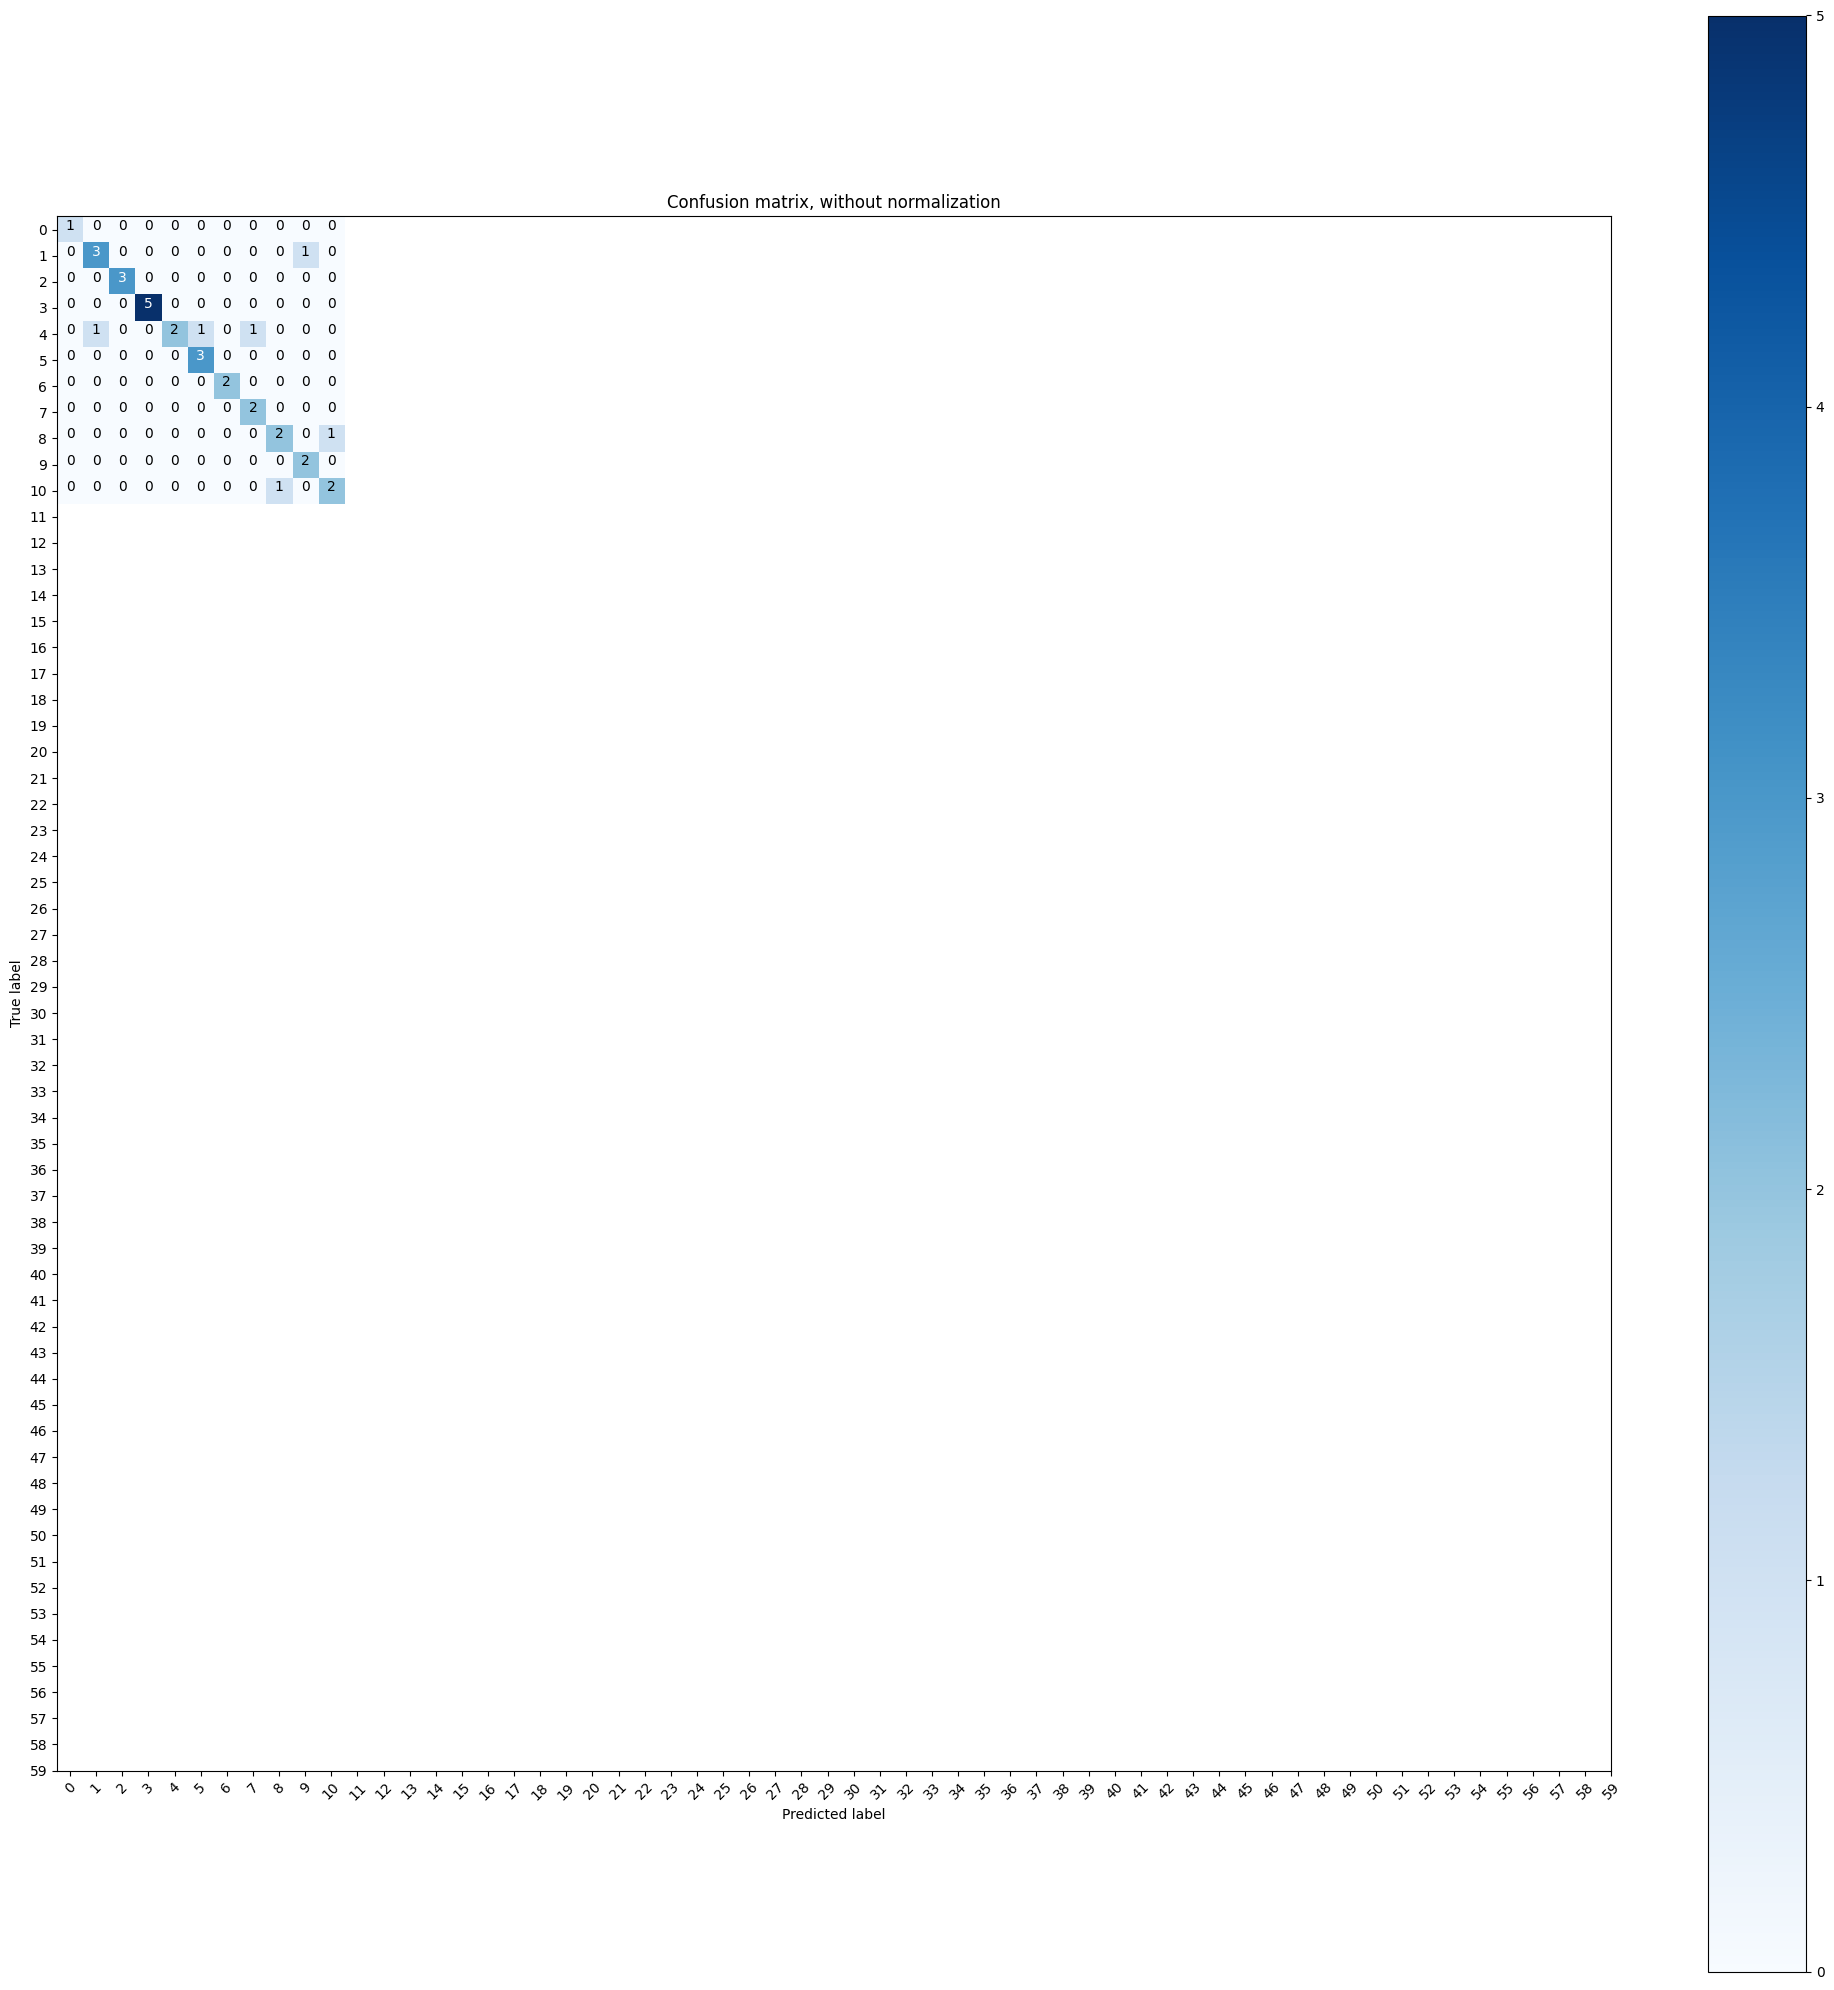

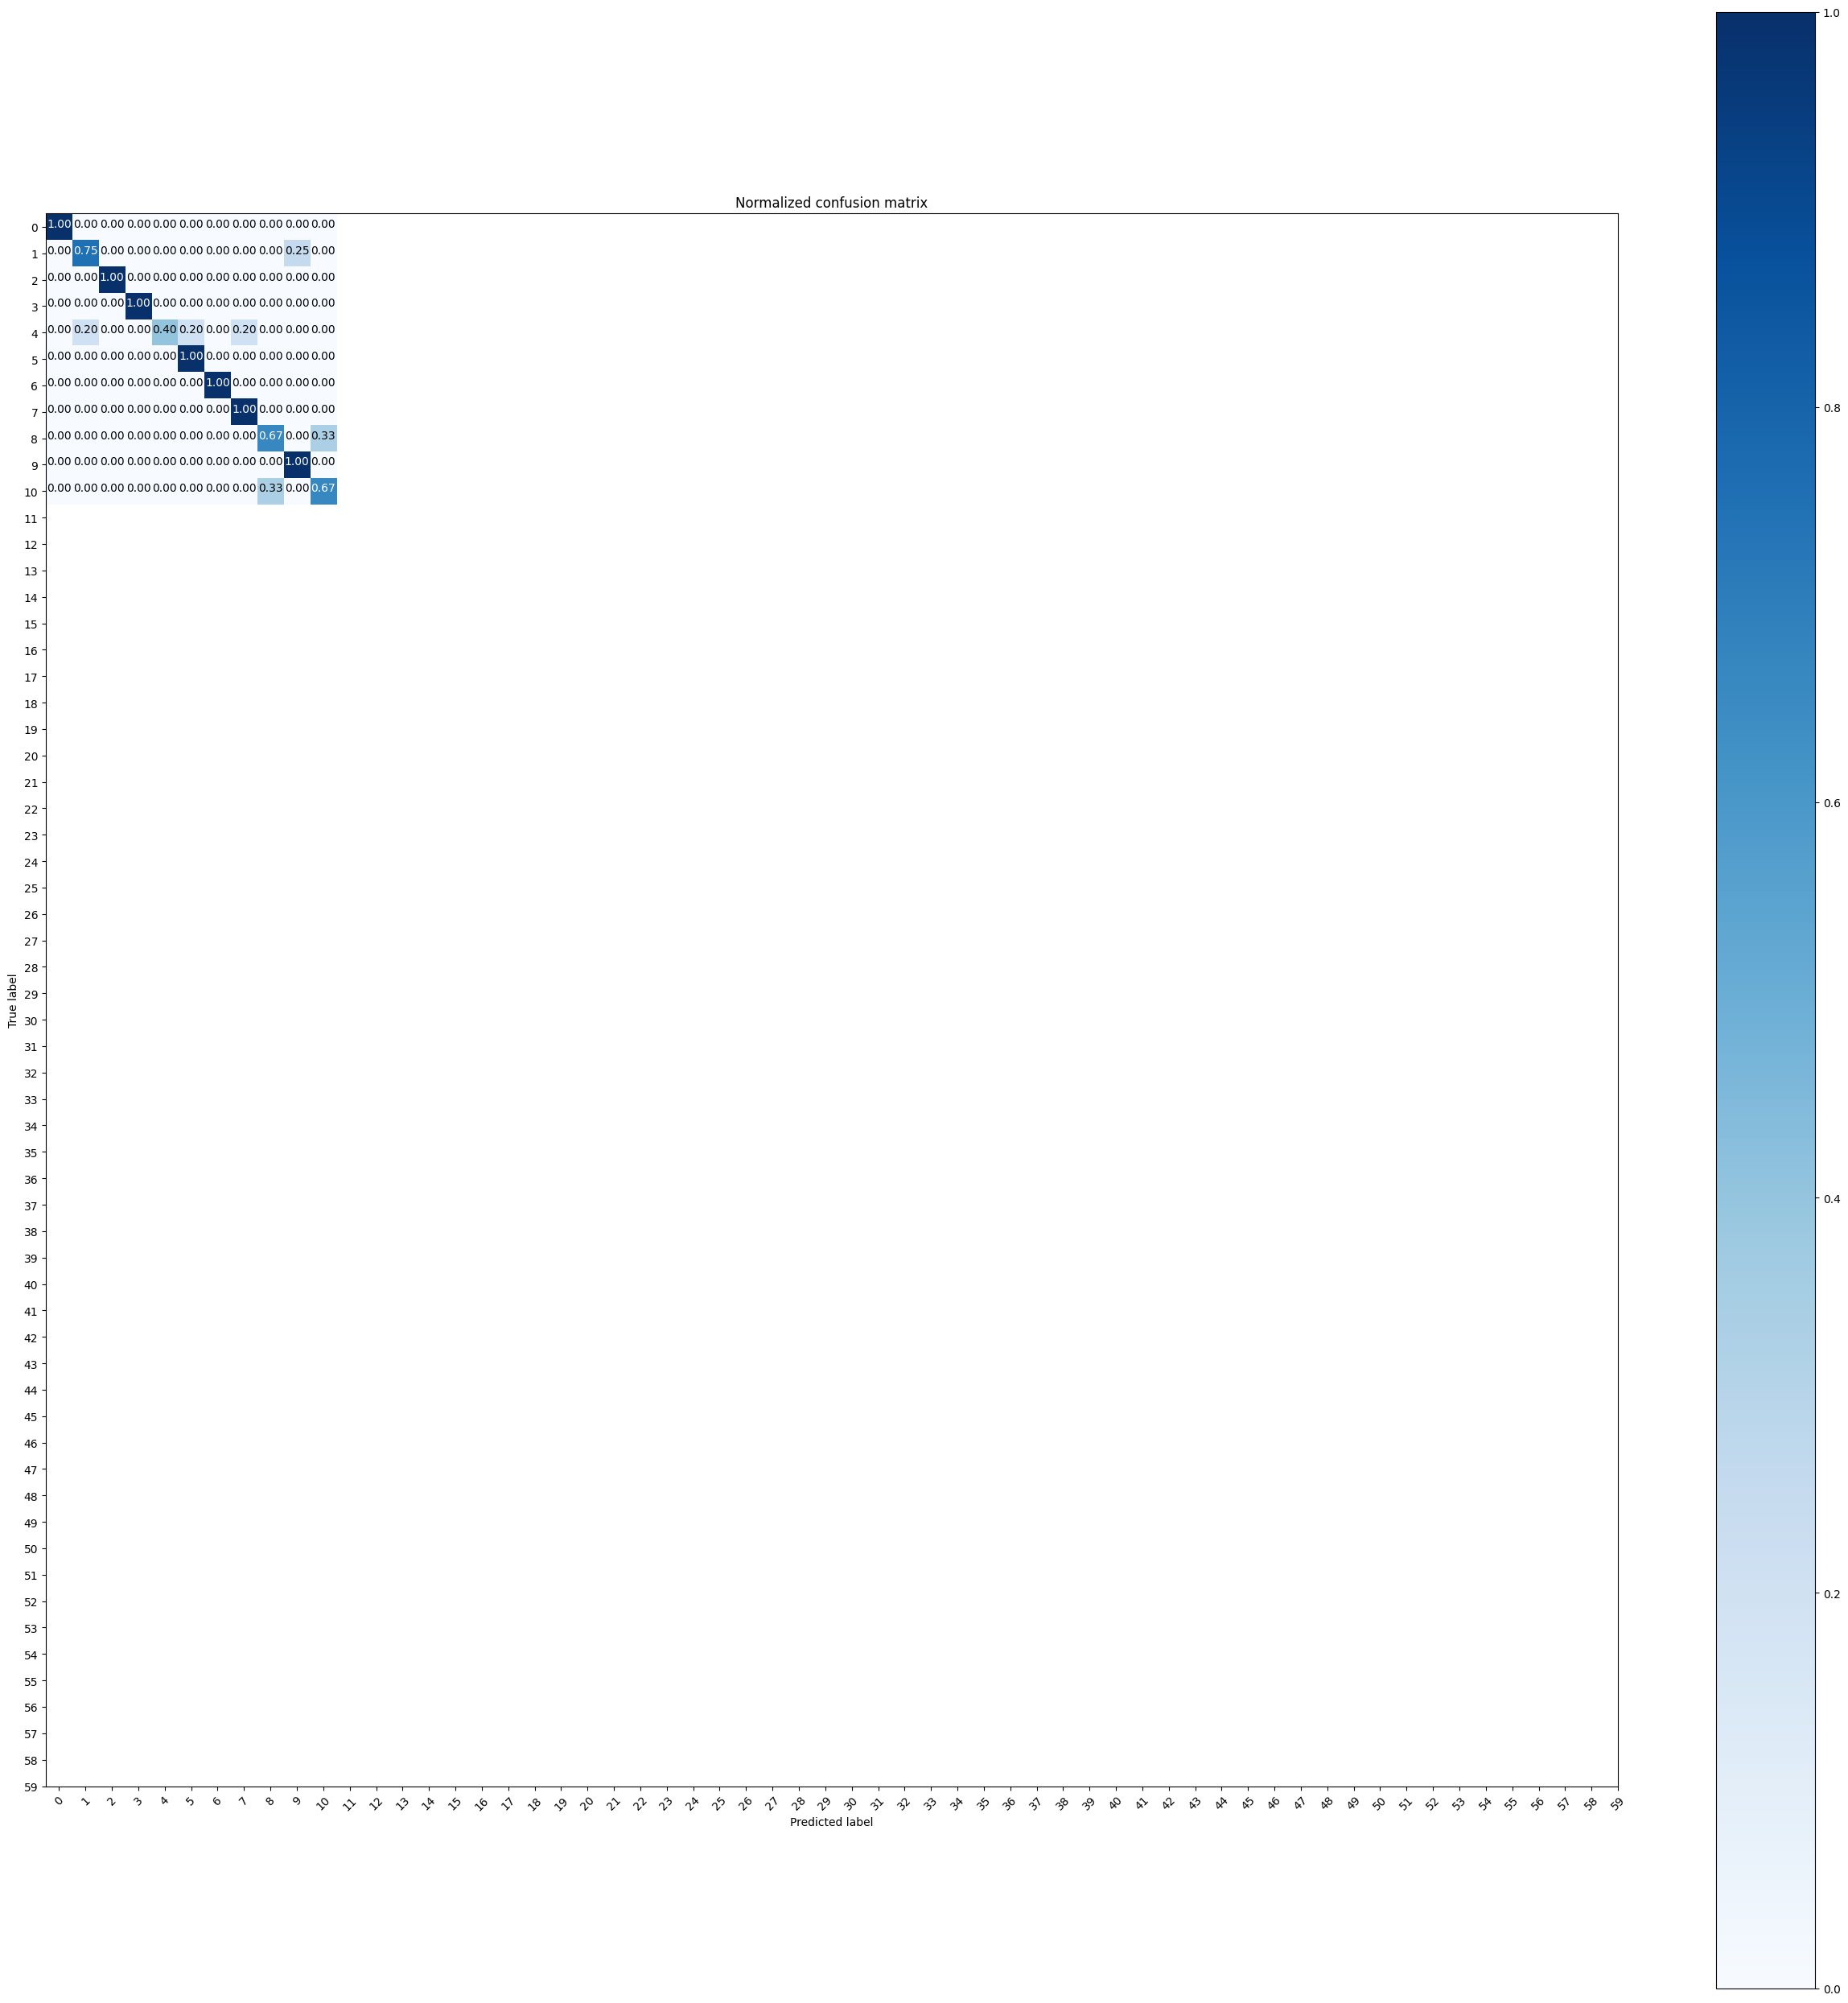

In [51]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
                26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
plt.figure(figsize = (20, 20))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize = (25, 25))
# plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()